In [1]:
import numpy as np 
import torch
import torch.nn as nn 
import torch.optim as optim

from torchvision import datasets, models, transforms, utils
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt 
import copy 
import os 
import time
plt.ion()   # interactive mode

In [2]:
batch_size = 2

### Loading the data

In [3]:
data_transform = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),

    ]), 
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

data_dir = "data"

train_data = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform["train"])
val_data = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transform["val"])

train_dataset = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataset = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)

classes = train_data.classes
print(classes)

train_size = len(train_data)
val_size = len(val_data)

print("train_size : ", train_size) 
print("val size : ", val_size)


device = "cpu"

['ants', 'bees']
train_size :  244
val size :  153


In [4]:
def print_images(inputs, title=None): 
    
    inp = np.transpose(np.array(inputs), (2, 1, 0))   
    print(inp.dtype)
    if title is not None: 
        plt.title(title) 
    plt.imshow(inp)
    plt.show()

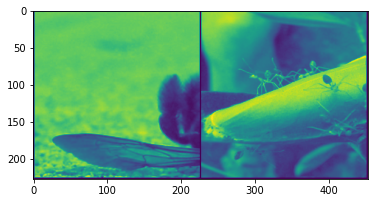

In [5]:
inputs, classes = next(iter(train_dataset))

image_grid = utils.make_grid(inputs)

plt.imshow(image_grid[0])

In [6]:
writer = SummaryWriter('runs/transfer')

# Write image data to TensorBoard log dir
writer.add_image('grid', image_grid)
writer.flush()

In [7]:
class TinyModel(torch.nn.Module):
    
    def __init__(self): 
        super(TinyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 96, 11, stride=4)
        self.pool1 = torch.nn.MaxPool2d(3, stride=2)
        self.conv2 = torch.nn.Conv2d(96, 256, 11, stride=4, padding=2)
        self.pool2 = torch.nn.MaxPool2d(3, stride=2)
        self.conv3 = torch.nn.Conv2d(256, 384, 3, padding=2)
        self.conv4 = torch.nn.Conv2d(384, 384, 3, padding=2)
        self.fc1 = nn.Linear(384*6*6, 80)
        self.fc2 = nn.Linear(80, 1)
        
    def forward(self, x): 
        x = torch.relu(self.conv1(x)) 
        x = self.pool1(x)
        x = torch.relu(self.conv2(x)) 
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        # important
        x = x.view(-1, 384 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
        

model = TinyModel()
model.to(device)
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=device, batch_size=2)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [2, 96, 54, 54]          34,944
         MaxPool2d-2            [2, 96, 26, 26]               0
            Conv2d-3             [2, 256, 5, 5]       2,973,952
         MaxPool2d-4             [2, 256, 2, 2]               0
            Conv2d-5             [2, 384, 4, 4]         885,120
            Conv2d-6             [2, 384, 6, 6]       1,327,488
            Linear-7                    [2, 80]       1,106,000
            Linear-8                     [2, 1]              81
Total params: 6,327,585
Trainable params: 6,327,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.15
Forward/backward pass size (MB): 5.68
Params size (MB): 24.14
Estimated Total Size (MB): 30.97
----------------------------------------------------------------


In [8]:
# optimization

optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [9]:
# training 

for epoch in range(10): 
    
    running_loss = 0.0
    for i, data in enumerate(train_dataset, 0): 
        inputs, true_labels = data
        true_labels = true_labels[:,None].float()
        
        # zero the parameter gradient 
        optimizer.zero_grad()

        outputs = model(inputs)        
        print(outputs)
        print(true_labels)
        loss = criterion(true_labels, outputs) 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / train_size

        print(epoch_loss)
        

tensor([[0.4929],
        [0.4930]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
0.4040833770251665
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)


nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[0.],
        [1.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.]])
nan
tensor([[nan],
        [nan]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
   

KeyboardInterrupt: 